In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.signal import find_peaks
import pandas as pd
import os
from sklearn.metrics import auc 
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

Load data file 

In [2]:
# load data into data frame
data_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Data/NBA_1510infections.csv'
data_df = pd.read_csv(data_file)
# list unique IDs
IDs = data_df.ID.unique()

# load parameters df, as this already has one row for each individual infection
parameters_file = r'/Users/kowens2/Downloads/estimatedIndividualParameters.txt'
parameters_df = pd.read_csv(parameters_file)

Filter to only those individuals with 3 weeks documented or clearance prior to 3 weeks.

In [3]:
# -- extract lower limit of quantification
LLOQ = data_df.y.min()

# -- add day of last test, day of first quantitative test and columns indicating whether these meet
# conditions for well documented case to the data frame
tlasttested = []
clearedby20 = []
t1stquanttest = []
lateQuant = []

for ii in data_df.ID.unique():
    df_id = data_df[data_df['ID'] ==ii].copy()
    t1stquanttest.append(np.min(np.array(df_id[df_id.y>LLOQ].time)))
    tlasttested.append(np.max(np.array(df_id.time)))
    if np.max(np.array(df_id.time))<=20 and list(df_id.y)[-1]<3:
        clearedby20.append(1)
    else:
        clearedby20.append(0)        
    if np.min(np.array(df_id[df_id.y>LLOQ].time)) > 5:
        lateQuant.append(1)
    else:
        lateQuant.append(0)


        
parameters_df['LastTest'] = tlasttested
parameters_df['Cleared'] = clearedby20
parameters_df['FirstQuantTest'] = t1stquanttest
parameters_df['LateQuant'] = lateQuant

documented = parameters_df[(parameters_df['LastTest']>20) + (parameters_df['Cleared']==1)].copy()
documented = documented[documented['LateQuant']<1].copy()

# Filter time series data to only include these IDs
IDlist = documented.id.unique()
def filterIDs(row,IDlist):
    if row.ID in IDlist:
        ret = 1
    else:
        ret = 0
    return ret

data_df['Documented20days'] = data_df.apply(lambda row: filterIDs(row,IDlist), axis = 1)

# -- new data frame with subset of cases
df_documented = data_df[data_df['Documented20days']>0].copy()
print(len(df_documented.ID.unique()))

810


In [4]:
# Filter so we retain at most one infection from each individual
import random
PIDS = [i.split('_')[0] for i in documented.id]
counts = [PIDS.count(i) for i in PIDS]
FilteredIDs = []
CheckDuplicates = []
CheckDuplicatesPID = []
for count, PID, i in zip(counts,PIDS, documented.id):
    if count == 1:
        FilteredIDs.append(i)
    else: 
        CheckDuplicates.append(i)
        CheckDuplicatesPID.append(PID)
        
CheckDuplicatesPID = set(CheckDuplicatesPID)
Keep = [random.randint(0,1) for x in range(len(CheckDuplicatesPID ))]

for k,PID in zip(Keep,CheckDuplicatesPID):
    options = list(documented.id[[p == PID for p in PIDS]])
    FilteredIDs.append(options[k])
    
df_documented['Keeper'] = df_documented.apply(lambda row: filterIDs(row,FilteredIDs), axis = 1)
df_documented = df_documented[df_documented['Keeper']>0].copy()
print(len(df_documented.ID.unique()))

768


In [5]:
def filterids(row,IDlist):
    if row.id in IDlist:
        ret = 1
    else:
        ret = 0
    return ret

documented['Keeper'] = documented.apply(lambda row: filterids(row,FilteredIDs), axis = 1)
documented = documented[documented['Keeper']>0].copy()
len(documented.id)

768

### Select hyperparameters for k-means clustering

(1) Elbow plot with different modes of interpolation and either 2 or 3 week window

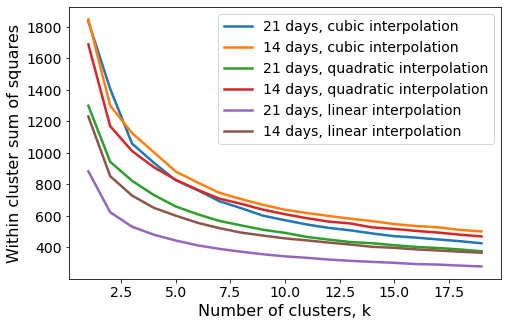

In [7]:
# -- 3 weeks
# Interpolate data to form trajectories
modes = [3, 2, 'linear']
label_modes = ['cubic', 'quadratic', 'linear']
df = df_documented

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,1, figsize = (7.75,5))


for i,mode in enumerate(modes):

    X = np.arange(-14,50)
    neg = 2.6576096821516124;

    for id in list(df.ID.unique()):
        df_id = df[df['ID'] ==id].copy()

        y_interp_1 = interp1d(df_id.time,df_id.y, kind = mode)
        xmin = np.min(df_id.time); 
        xmax = np.max(df_id.time);

        y_tested = y_interp_1(np.arange(xmin,xmax,1))
        y_tested = np.concatenate((neg*np.ones((xmin+14)),y_tested ))
        times = np.arange(-14,xmax)
        y_tested = np.concatenate((y_tested,neg*np.ones((50-xmax)), ))
        times = np.arange(-14,50)

        X = np.vstack((X,np.maximum(y_tested, neg)))

    times = X[0,:]
    ppl = X[1:,:]

    for end in [-30,-37]:
        X = ppl[:,14:end]
        N = np.shape(X)[1]
        t = times[14:end]
        ssq = []
        for k in range(1,20):
            kmeans = KMeans(n_clusters=k).fit(X)
            ssq.append(kmeans.inertia_/N)
            #inertia is the sum of squared distances of samples to their closest cluster center

        plt.plot(np.arange(1,20),ssq, linewidth = 2.5, label = str(N+1)+ ' days, ' + label_modes[i] + ' interpolation' )
        plt.xlabel('Number of clusters, k', fontsize = 16)
        plt.ylabel('Within cluster sum of squares', fontsize = 16)
    
plt.legend()
plt.show()

(2) Try out different values of k. It looks like 4-6 makes sense

In [8]:
# Use linear interpolation, 3 week window of observation to contstruct the data

mode =  'linear'
df = df_documented
X = np.arange(-14,50)
neg = 2.6576096821516124;

for id in list(df.ID.unique()):
    df_id = df[df['ID'] ==id].copy()

    y_interp_1 = interp1d(df_id.time,df_id.y, kind = mode)
    xmin = np.min(df_id.time); 
    xmax = np.max(df_id.time);

    y_tested = y_interp_1(np.arange(xmin,xmax,1))
    y_tested = np.concatenate((neg*np.ones((xmin+14)),y_tested ))
    times = np.arange(-14,xmax)
    y_tested = np.concatenate((y_tested,neg*np.ones((50-xmax)), ))
    times = np.arange(-14,50)

    X = np.vstack((X,np.maximum(y_tested, neg)))

times = X[0,:]
ppl = X[1:,:]

end = -30
X = ppl[:,14:end]
N = np.shape(X)[1]
t = times[14:end]

[221, 166, 224, 157]
[171, 179, 160, 142, 116]
[133, 167, 157, 141, 73, 97]
[121, 126, 109, 112, 137, 72, 91]
[88, 116, 113, 118, 111, 72, 96, 54]


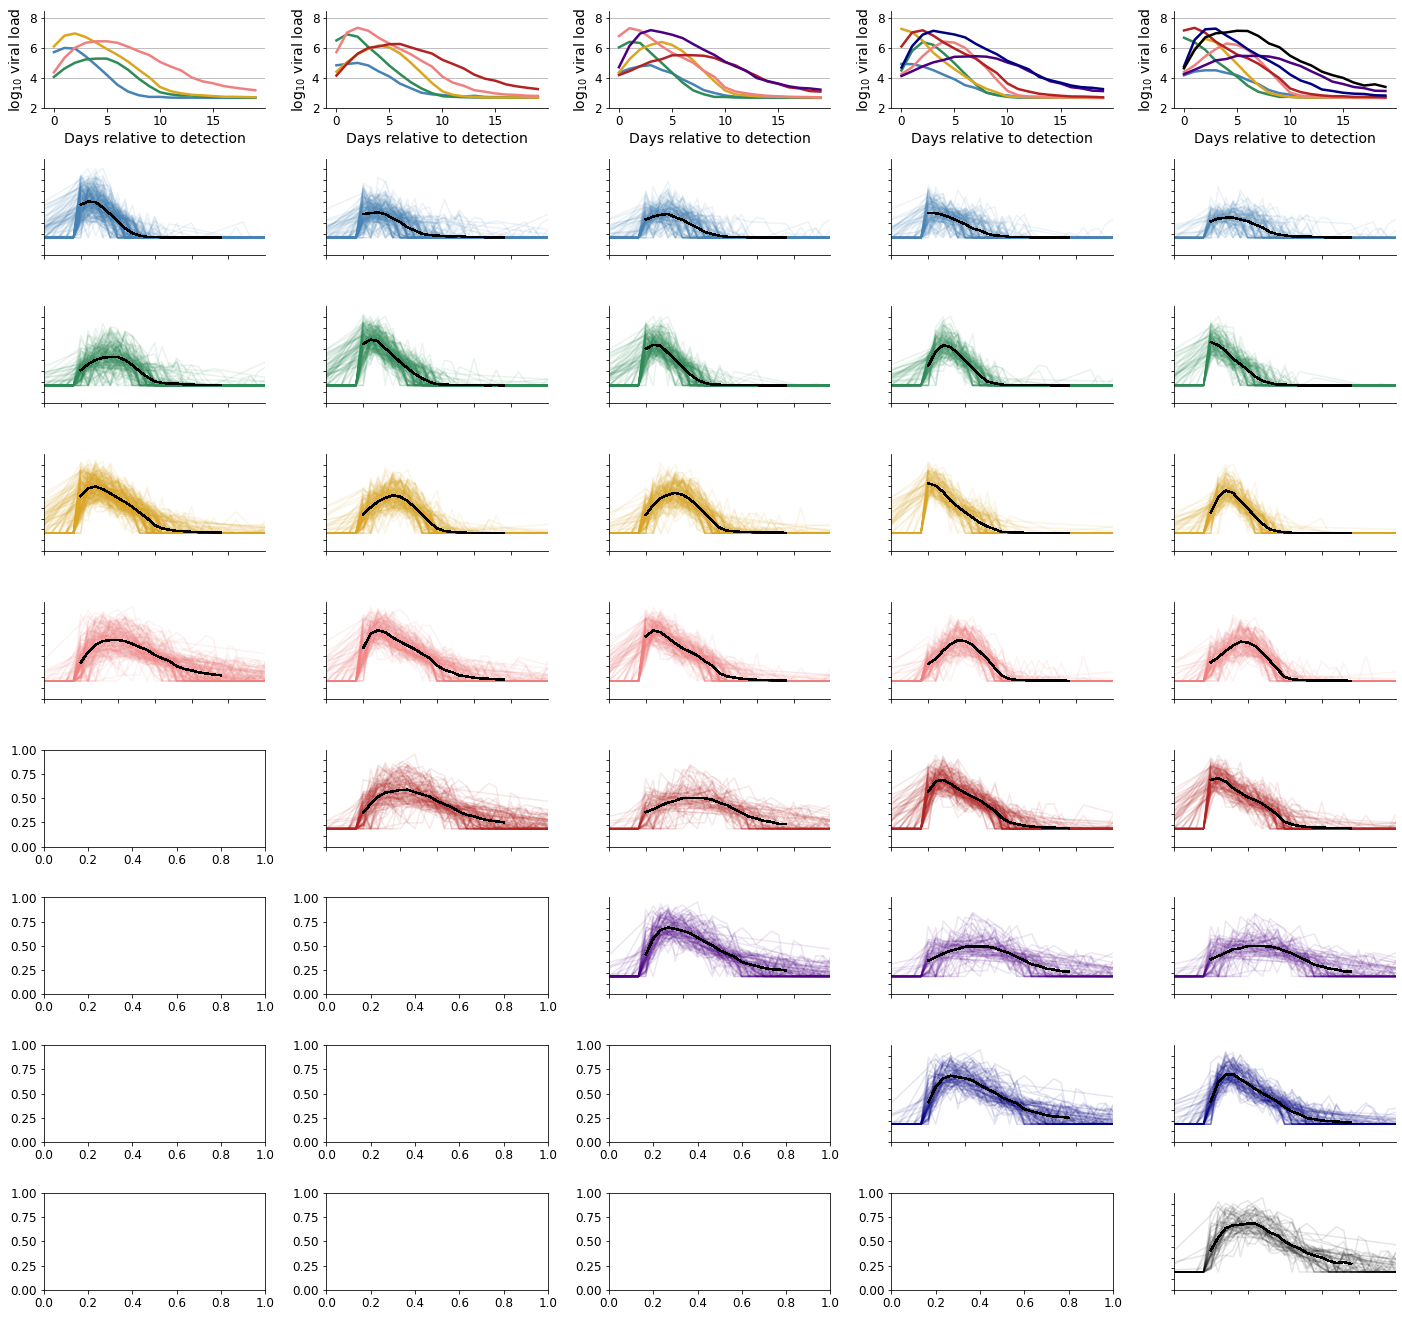

In [14]:
colors = [ 'steelblue','seagreen','goldenrod','lightcoral', 'firebrick','indigo', 'navy', 'k']
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(9,5, figsize = (4.95*4, 2.3*8))
for jj,k in enumerate([4,5,6,7,8]):
    # kmeans clustering
    kmeans = KMeans(n_clusters=k).fit(X)
    # sort the centers by auc for consistent ordering
    centers = [auc(t,y) for y in kmeans.cluster_centers_]
    sort_index = np.argsort(centers)

    # build color dictionary
    Dict = dict([(x,c) for x,c in zip(sort_index, colors)])
    
    # plot the centers
    order = sort_index  
    for count in order:
        cc = kmeans.cluster_centers_[count]
        axs[0,jj].plot(t,cc, color = Dict[count], linewidth = 2.5)

    axs[0,jj].set_ylim(2,8.5)
    axs[0,jj].grid(axis = 'y')    
    axs[0,jj].set_xlabel('Days relative to detection', fontsize=14)
    axs[0,jj].set_ylabel('log$_{10}$ viral load', fontsize=14)
    axs[0,jj].spines['top'].set_visible(False)
    axs[0,jj].spines['right'].set_visible(False)
    print([np.sum(kmeans.labels_== c) for c in order])
    for count, label in enumerate(kmeans.labels_):
        p = np.where(order == label)[0][0]+1
        axs[p,jj].plot(times,ppl[count,:], color = Dict[label], alpha = 0.1)

        center_inds = []
        for count,cc in enumerate(kmeans.cluster_centers_):
            idx = np.argmin(np.sqrt(np.sum(np.abs(X-cc)**2, axis = 1)))
            label = kmeans.labels_[idx]
            p = np.where(order == label)[0][0]+1
            axs[p,jj].plot(t,cc, color = 'k')
            axs[p,jj].set_ylim(2,10)
            axs[p,jj].set_xlim(-5,25)
            center_inds.append(idx)
            axs[p,jj].set_yticks(np.arange(1,10))
            axs[p,jj].set_xticks(np.arange(-5,25,5))
            axs[p,jj].set_xticklabels([])
            axs[p,jj].set_yticklabels([])
            axs[p,jj].spines['top'].set_visible(False)
            axs[p,jj].spines['right'].set_visible(False)
            
plt.tight_layout()
plt.show()

### Further examine results with k=6

Include additional columns in data frame in order to be able to associate these with clustering results.

In [15]:
df = df_documented
# None --> omicron
documented.loc[documented.cat_LineageBroad == 'None', 'cat_LineageBroad'] = 'Omicron'
# Include column with quantitative kinetic features computed from data directly
PIDs = documented.id
# Add a column for the peak viral load
Peak = []
for p in PIDs:
    df_ind = df[df['ID'] == p]
    Peak.append(df_ind['y'].max())
documented['Peak'] = Peak

# Add a column for the time to peak viral load
TTP = []
for p in PIDs:
    df_ind = df[df['ID'] == p]
    TTP.append(df_ind.loc[df_ind['y'].idxmax()].time) 
documented['PeakTime'] = TTP

# Add a column for the duration
Durations = []
for p in PIDs:
    df_ind = df[df['ID'] == p]
    df_pos = df_ind[df_ind.y > LLOQ]
    Durations.append(df_pos['time'].max())   
documented['Duration'] = Durations

# Add a column for AUC
AUCs = []
for p in PIDs:
    df_ind = df[df['ID'] == p]
    AUCs.append(auc(df_ind.time, df_ind.y))
documented['AUL10C'] = AUCs

Execute the k-means clustering. Use a seed for replicability.

In [16]:
modes = ['linear']
df = df_documented
for mode in modes:

    X = np.arange(-14,50)
    neg = 2.6576096821516124;

    for id in list(df.ID.unique()):
        df_id = df[df['ID'] ==id].copy()

        y_interp_1 = interp1d(df_id.time,df_id.y, kind = mode)
        xmin = np.min(df_id.time); 
        xmax = np.max(df_id.time);

        y_tested = y_interp_1(np.arange(xmin,xmax,1))
        y_tested = np.concatenate((neg*np.ones((xmin+14)),y_tested ))
        times = np.arange(-14,xmax)
        y_tested = np.concatenate((y_tested,neg*np.ones((50-xmax)), ))
        times = np.arange(-14,50)

        X = np.vstack((X,np.maximum(y_tested, neg)))

    times = X[0,:]
    ppl = X[1:,:]


X = ppl[:,14:-30]
t = times[14:-30]
k = 6

kmeans = KMeans(n_clusters=k, random_state = 10).fit(X)

centers = [auc(t,y) for y in kmeans.cluster_centers_]
sort_index = np.argsort(centers)

def reorder(l, sort_index):
    new_label = np.argwhere(sort_index==l)[0][0]
    return new_label

# add cluster results to data frame.
documented['DynamicCluster'] = kmeans.labels_
documented['DynamicClusterOrdered'] = [reorder(l,sort_index) for l in kmeans.labels_]

Plot cluster centers and all trajectories from each cluster.

[134, 173, 133, 156, 76, 96]


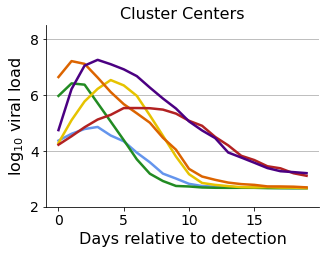

In [17]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(figsize = (4.75,3.75), frameon = False)

colors = ['cornflowerblue','forestgreen', [230/255,195/255,0],[220/255,100/255,0], 'firebrick', 'indigo']
Dict = dict([(x,c) for x,c in zip(sort_index, colors)])

for count in sort_index:
    cc = kmeans.cluster_centers_[count]
    plt.plot(t,cc, color = Dict[count], linewidth = 2.5)


plt.ylim(2,8.5)
plt.grid(axis = 'y')    
plt.xlabel('Days relative to detection', fontsize=16)
plt.ylabel('log$_{10}$ viral load', fontsize=16)
plt.title('Cluster Centers', fontsize=16)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

print([np.sum(kmeans.labels_== c) for c in sort_index])
plt.tight_layout()

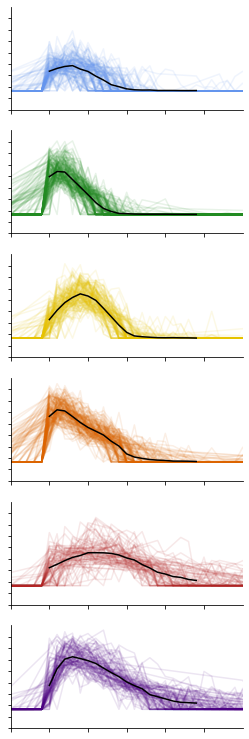

In [18]:
# Plot time series for each cluster

fig, axs = plt.subplots(6,1, figsize = (3.75, 10.55))
plt.rcParams.update({'font.size': 16})

for count, label in enumerate(kmeans.labels_):
    p = np.where(sort_index == label)[0][0]
    axs[p].plot(times,ppl[count,:], color = Dict[label], alpha = 0.1)
    
center_inds = []
for count,cc in enumerate(kmeans.cluster_centers_):
    idx = np.argmin(np.sqrt(np.sum(np.abs(X-cc)**2, axis = 1)))
    label = kmeans.labels_[idx]
    p = np.where(sort_index == label)[0][0]
    axs[p].plot(t,cc, color = 'k')
    axs[p].set_ylim(2,10)
    axs[p].set_xlim(-5,25)
    center_inds.append(idx)
    axs[p].set_yticks(np.arange(1,10))
    axs[p].set_xticks(np.arange(-5,25,5))
    axs[p].set_xticklabels([])
    axs[p].set_yticklabels([])
    axs[p].spines['top'].set_visible(False)
    axs[p].spines['right'].set_visible(False)
    
plt.tight_layout()

Make heat map. 

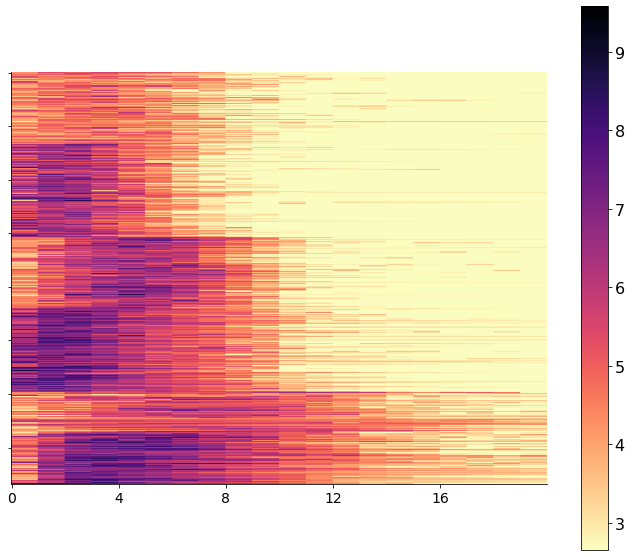

In [19]:
# Reorder X
viz = X[kmeans.labels_==sort_index[0],:]
for nn in sort_index[1:]:
    viz = np.concatenate((viz,X[kmeans.labels_==nn,:]))
    
# Add additional columns to spread out for visualization
r_viz = np.repeat(viz, repeats=50, axis=1)

# Make heat map
fig, ax = plt.subplots(figsize = (12,10));
plt.imshow(r_viz, cmap = 'magma_r');
plt.colorbar()
ax.set_xticklabels([0,0,4,8,12,16,20], fontsize=14)
ax.set_yticklabels([], fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### How do properties of the clusters differ?

(1) Additional data on the infections

In [20]:
# -- add column to the data frame that has one row per infection

values = list(documented['DynamicClusterOrdered'])
PIDs = documented.id.unique()
NewCol = []
for i,p in enumerate(PIDs):
    df_ind = df_documented.loc[df_documented.ID == p,:]
    value = values[i]
    NumRows = len(df_ind)
    x = list(np.repeat(value,NumRows))
    NewCol.extend(x)
df_documented['Cluster'] = NewCol

# --- Function for plotting stacked bar charts
def BuildStackedBarPlot(df,cats,col_name, xlabel):
    counts = []
    for cat in cats:
        df1 = df[df[col_name] == cat].copy()
        varcounts = []
        for label in np.arange(0,6):
            varcounts.append(100*len(df1[df1['DynamicClusterOrdered']==label])/len(df1))

        counts.append(varcounts)
        print(len(df1))
    dtop = pd.DataFrame(counts,
                       columns=['1','2','3','4','5','6'])
    dtop[xlabel] = cats
    dtop.plot(
      x = xlabel, 
      kind = 'barh', 
      stacked = True,  
      mark_right = True,
      legend = False,
    color = colors,
    edgecolor = 'white',
    alpha = 0.5,
    figsize=(4.5, 3.5))
    sns.despine(top=True)
    sns.despine(right=True)
    sns.despine(left=True)
    plt.show()
    
# --- Function for printing percentages shown in bar charts
def BuildTable(df,cats,col_name):
    counts = []
    totals = []
    for cat in cats:
        df1 = df[df[col_name] == cat].copy()
        varcounts = []
        for label in np.arange(0,6):
            varcounts.append(np.round(100*len(df1[df1['DynamicClusterOrdered']==label])/len(df1)))
        counts.append(varcounts)

    dtop = pd.DataFrame(counts,
                       columns=['1','2','3','4','5','6'])
    dtop['values'] = cats
    print(dtop)


      1     2     3     4     5     6   values
0  22.0  30.0  20.0  20.0   3.0   5.0  Omicron
1   9.0  19.0  15.0  31.0   8.0  19.0    Delta
2   9.0   2.0  11.0  15.0  30.0  32.0    Other
496
102
170


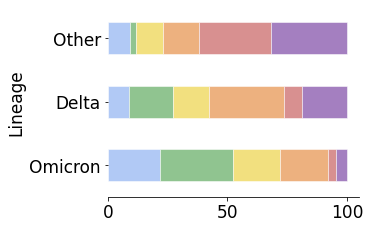

      1     2     3     4     5     6        values
0  22.0  26.0  22.0  20.0   4.0   5.0       Boosted
1  19.0  28.0  21.0  21.0   4.0   7.0   Second dose
2   9.0   1.0  16.0  11.0  29.0  34.0  Unvaccinated
238
228
108


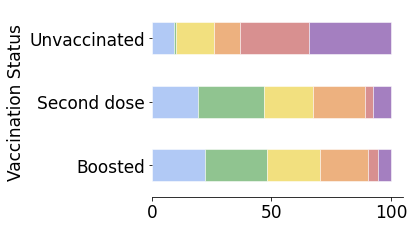

In [21]:
# Generate the plots
# -- variant: 'cat_LineageBroad'
plt.rcParams.update({'font.size': 17})
cats = [ 'Omicron','Delta','Other']
col = 'cat_LineageBroad'
xlabel = 'Lineage'
BuildTable(documented,cats,col)
BuildStackedBarPlot(documented,cats,col, xlabel)


# -- vaccination status: 'cat_VaccStatus'
cats = ['Boosted', 'Second dose',  'Unvaccinated']
col = 'cat_VaccStatus'
xlabel = 'Vaccination Status'
BuildTable(documented,cats,col)
BuildStackedBarPlot(documented,cats,col, xlabel)




      1     2     3     4     5     6 values
0  17.0  25.0  21.0  17.0   9.0  12.0      1
1  14.0  22.0  21.0  20.0  10.0  12.0      2
2   9.0   6.0  11.0  34.0  14.0  25.0      3
378
311
79


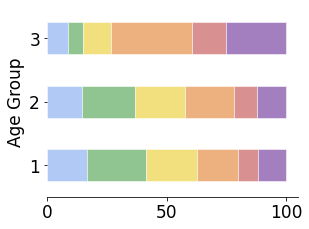

      1     2     3     4    5    6 values
0  14.0  29.0  22.0  25.0  3.0  7.0    Yes
1  29.0  23.0  31.0  10.0  4.0  4.0     No
308
124


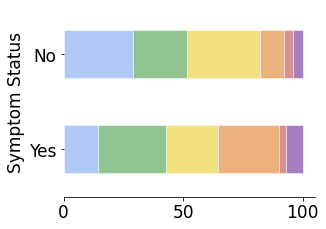

In [76]:
# -- age group: 'cat_AgeGroup'
cats = ['1', '2', '3']
col = 'cat_AgeGroup' 
xlabel = 'Age Group'
BuildTable(documented,cats,col)
BuildStackedBarPlot(documented,cats,col, xlabel)


# -- symptomatic vs. asymptomatic: 'cat_SympEver'
cats = ['Yes', 'No']
col = 'cat_SympEver'
xlabel = 'Symptom Status'
BuildTable(documented,cats,col)
BuildStackedBarPlot(documented,cats,col, xlabel)

      1     2     3     4     5     6  values
0  18.0  24.0  18.0  20.0   9.0  12.0       0
1   8.0   0.0  11.0  34.0  24.0  24.0       1
730
38


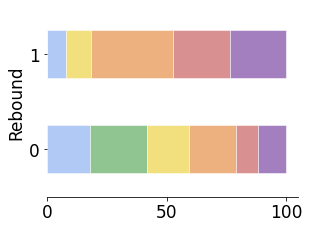

      1     2     3     4     5     6   values
0  13.0  23.0  23.0  27.0   4.0   9.0        1
1  11.0  28.0  20.0  27.0   5.0   9.0        2
2  19.0  22.0  16.0  18.0  12.0  14.0  unknown
137
64
567


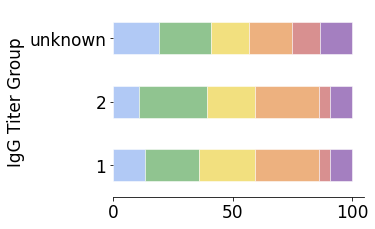

In [22]:
# -- rebound cases vs. non rebound cases -- need to pull over the results from modeling
cats = [0,1]
col = 'cat_Rebound'
xlabel = 'Rebound'
BuildTable(documented,cats,col)
BuildStackedBarPlot(documented,cats,col, xlabel)


# -- titer group -- look at column with 3 groups
cats = ['1', '2', 'unknown']
col = 'cat_TiterGroup'
xlabel = 'IgG Titer Group'
BuildTable(documented,cats,col)
BuildStackedBarPlot(documented,cats,col, xlabel)



(2) Quantitative kinetic features

In [23]:
from sksurv.nonparametric import kaplan_meier_estimator
def CalculateClearedProportion(df,thresh):
    time_observed = []
    status = []

    for i,inf in enumerate(df.ID.unique()):
        df_id = df[df['ID']==inf]
        try:
            t = np.array(df_id[df_id.time >=0].time)
            y = np.array(df_id[df_id.time >=0].y) 
            date_measured = t[y<=thresh][0]
            clearance_indicator = True
        except:
            date_measured = t[-1]
            clearance_indicator = False
        time_observed.append(date_measured)
        status.append(clearance_indicator)
        
    time, survival_prob, CI = kaplan_meier_estimator(status, time_observed, conf_level=0.95, conf_type='log-log')
    return time, survival_prob, CI

def ConvertToIncidence(x, ref):
    return 100*(1-x -(1-ref))

(0.0, 40.0)

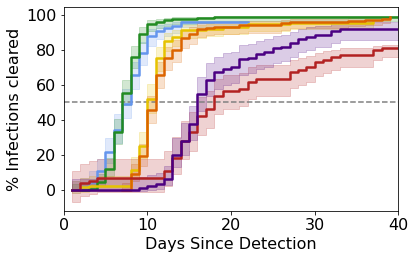

In [24]:
fig, axs = plt.subplots(figsize = (6,3.75))
plt.rcParams.update({'font.size': 16})
thresh = 2.6576096821516124

for i in np.arange(0,6):
    df_1 = df_documented[df_documented['Cluster'] == i].copy()
    time1, survival_prob1, CI1 = CalculateClearedProportion(df_1,thresh)
    plt.fill_between(time1, ConvertToIncidence(CI1[0],survival_prob1[0]), ConvertToIncidence(CI1[1],survival_prob1[0]), color = colors[i], alpha=0.2, step="post")
    plt.step(time1, 100*(1-survival_prob1-(1-survival_prob1[0])), where="post", color = colors[i], label = 'Group '+str(i+1), lw = 2.5)
    
plt.hlines(y = 50, xmin = 0, xmax = 50, ls = '--', color = 'tab:gray')
plt.xlabel('Days Since Detection', fontsize = 16);
plt.xticks([0, 10, 20, 30 ,40 ,50],fontsize = 16);
plt.ylabel('% Infections cleared', fontsize = 16);
plt.yticks([0,  20, 40 ,60,80,100],fontsize = 16);
plt.xlim([0,40])

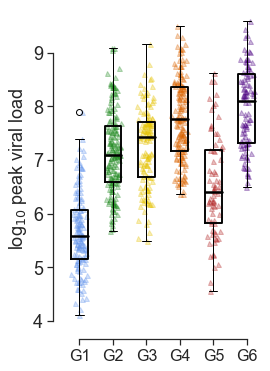

In [25]:
# Boxplots for quantitative features of viral load data by cluster
from scipy.stats import ttest_ind
from statannotations.Annotator import Annotator


def BoxPlot(df, feature, numclusters = 6, 
            ylabel = [], yaxis = 'linear', ylim = [], pairs = [], h = 0.25, colors = colors):
    all_data = []
    labels = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6']
    colors = colors + ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']
    sns.set(style='ticks')
    # Actual plotting
    fig = plt.figure(figsize=(4.1,5.5), dpi=72, facecolor="white")#figsize=(3.5,7)
    plt.rcParams.update({'font.size': 18})
    axes = plt.subplot(111)
    for i,l in enumerate(np.arange(0,numclusters)):
        temp = df[df.DynamicClusterOrdered == l][feature]
        y = temp.tolist()
        x = np.random.normal(i, 0.1, size=len(y))
        if yaxis == 'linear':
            all_data.append(y)
            plt.plot(x, y, '^',color = colors[l], alpha=0.3, markersize = 5)
        elif yaxis == 'log':
            all_data.append(np.log10(y))
            plt.plot(x, np.log10(y), '^',color = colors[l], alpha=0.3, markersize = 5)
            
    boxprops = dict(color="black",linewidth=1.9)
    medianprops = dict(color="black",linewidth=2.5)
    plt.boxplot(all_data, labels=labels,boxprops=boxprops,medianprops=medianprops,positions = np.arange(0,numclusters));
    if ylim:
        plt.ylim(ylim)
    sns.despine(ax=axes, offset=10, trim=True)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=16)
    #plt.xlabel('dynamic cluster', fontsize = 16)
    if ylabel:
        plt.ylabel(ylabel, fontsize = 18)
        #
    else:
        plt.ylabel(feature, fontsize = 16)
    if len(pairs) >=1:
        annotator = Annotator(axes, pairs, data=df, x='DynamicClusterOrdered', y=feature)
        annotator.configure(test="Mann-Whitney")
        annotator.apply_and_annotate()
    fig.tight_layout()
    plt.show()
    return None
all_pairs = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4), (3,5),(4,5)]
p = []

BoxPlot(documented, 'Peak', numclusters = 6, ylabel = 'log$_{10}$ peak viral load', pairs = [], h = 0.25)

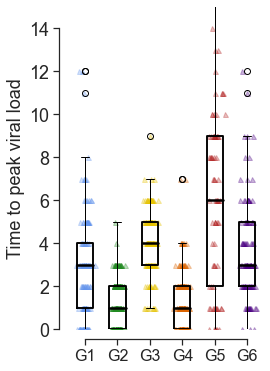

In [26]:
p = [(0,1),(0,2),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)]
BoxPlot(documented, 'PeakTime', numclusters = 6, ylabel = 'Time to peak viral load',ylim = [0,15], pairs = [])

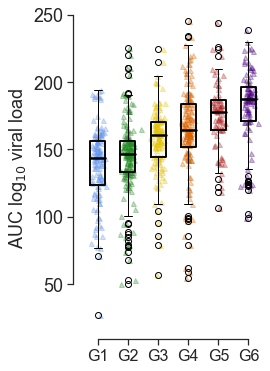

In [27]:
BoxPlot(documented, 'AUL10C', numclusters = 6, ylabel = r'AUC log$_{10}$ viral load', pairs = [], h = 5)

In [83]:
clusters2 = []
for ID in parameters_df.id.unique(): 
    if ID in list(documented.id):
        cluster2 = list(documented[documented['id']==ID].DynamicClusterOrdered)[0]
        clusters2.append(cluster2)
    else:
        clusters2.append(10)
parameters_df['Cluster'] = clusters2

In [ ]:
# Remove those who are not early detectors, export data frame with fully documented infections for model selection
df_ForModelSelection = df_documented[df_documented['cat_EarlyDetection'] > 0]
df_ForModelSelection.to_excel(r'/Users/kowens2/Documents/SARS-CoV-2 Rebound/NBACohortMay2023/DataPreProcessing/NBA_6Clusters_266infections.xlsx')

In [84]:
# Export data frame with cluster labels for all individuals used in clustering
df_documented.to_excel(r'/Users/kowens2/Documents/SARS-CoV-2 Rebound/NBACohortMay2023/DataPreProcessing/NBA_6Clusters_768infections.xlsx')